# British Airways (BA) Customer Review Data Analysis
This script is written to collect customer feedback through data scraping and to understand the customers' needs and opinions about BA through data analysis. Customer review data is obtained from a third party source, [Skytrax](https://www.airlinequality.com/airline-reviews/british-airways). The data is analysed using topic modelling methods including NMF and LDA. Sentiment analysis was carried out using VADER and a word cloud was generated. Customer review data is essential for understanding the general customer experience and what the customer values, hence BA can improve on those qualities to provide better customer experience. 

This project is the first task of the British Airways Data Science virtual experience programme.[¹](https://www.theforage.com/virtual-internships/NjynCWzGSaWXQCxSX?ref=Z3KC3m2z3qvoMguDz)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

#Data Scraping
import requests
from bs4 import BeautifulSoup as bs

#Data Cleaning
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re

#Word Cloud
from wordcloud import WordCloud

#Topic Modelling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

#Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns

## Data Scraping

In [18]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages=35
page_size=100

reviews=[]
for i in range(1,pages+1):
    print(f"Scraping page {i}")
    
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"
    
    response = requests.get(url)
    
    content = response.content
    parsed_content = bs(content, "html.parser")
    for para in parsed_content.find_all("div",{"class":"text_content"}):
        reviews.append(para.get_text())
    print(f"{len(reviews)} total reviews")

Scraping page 1
100 total reviews
Scraping page 2
200 total reviews
Scraping page 3
300 total reviews
Scraping page 4
400 total reviews
Scraping page 5
500 total reviews
Scraping page 6
600 total reviews
Scraping page 7
700 total reviews
Scraping page 8
800 total reviews
Scraping page 9
900 total reviews
Scraping page 10
1000 total reviews
Scraping page 11
1100 total reviews
Scraping page 12
1200 total reviews
Scraping page 13
1300 total reviews
Scraping page 14
1400 total reviews
Scraping page 15
1500 total reviews
Scraping page 16
1600 total reviews
Scraping page 17
1700 total reviews
Scraping page 18
1800 total reviews
Scraping page 19
1900 total reviews
Scraping page 20
2000 total reviews
Scraping page 21
2100 total reviews
Scraping page 22
2200 total reviews
Scraping page 23
2300 total reviews
Scraping page 24
2400 total reviews
Scraping page 25
2500 total reviews
Scraping page 26
2600 total reviews
Scraping page 27
2700 total reviews
Scraping page 28
2800 total reviews
Scraping p

In [180]:
df.to_csv("BA_reviews.csv")

## Data Cleaning

In [3]:
df2 = pd.read_csv("BA_reviews.csv")

In [4]:
stop = set(stopwords.words('english'))
punc = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'
# set of additional words to remove as these are unlikely to be useful for understanding the customer's experiences
remove = set(['ba','✅', 'trip','verified','not','british','airway','airline','flight','airways','flights','plane', 'aircraft','one','get','would','really','first','could','even','told','also','still','u','airlines','airport'])
lemma = WordNetLemmatizer()

def clean(line):
    stop_free = " ".join([i for i in line.lower().split() if i not in stop])
    removed = " ".join([i for i in stop_free.split() if i not in remove])
    no_free = re.sub('[0-9]+','',removed)
    punc_free = re.sub('['+punc+']+','',no_free)
    normalised = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalised

cleaned = [clean(line) for line in df2['Reviews'].values]

In [5]:
df3 = pd.DataFrame()
df3['Cleaned Reviews'] = cleaned
df3.to_csv("BA_reviews(Cleaned).csv")

In [6]:
#create a copy of the dataset where the reviews are in full sentences for sentiment analysis. 
remove2 = set(['✅','Verified','Not','Trip','|'])

def clean_SA(line):
    cleaned = " ".join([i for i in line.split() if i not in remove2])
    return cleaned
cleaned_SA = [clean_SA(line) for line in df2['Reviews'].values]

## Word Cloud

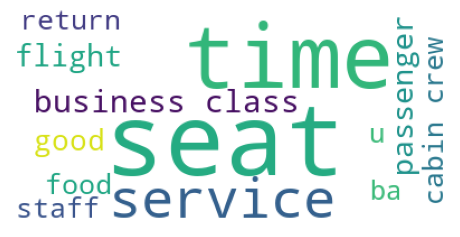

In [46]:
rev_words=''
for line in cleaned:
    tokens = line.split()  
    rev_words+=" ".join(tokens)+" "
wordcloud = WordCloud(stopwords=stop,background_color ='white',min_font_size = 15).generate(rev_words)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('wordcloud.png',bbox_inches='tight')

In [226]:
wordfreq = {}
for word in rev_words.split():
    if word not in wordfreq:
        wordfreq[word] = 0
    wordfreq[word] += 1
word_df = pd.DataFrame.from_dict([wordfreq])   
index = word_df.values[0].argsort()[-10:][::-1]

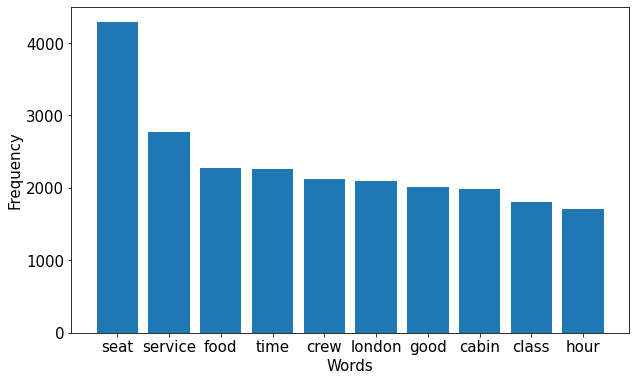

In [233]:
fig = plt.figure(facecolor='white',figsize=(10,6))
plt.bar(word_df.columns[index],word_df.values[0][index])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Words',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.savefig('FreqWords.png',bbox_inches='tight')

## Topic Modelling

### LDA

In [54]:
vectorizer = CountVectorizer(max_df=0.9,min_df=0.1)
tf = vectorizer.fit_transform(cleaned).toarray()
tf_feature_names= vectorizer.get_feature_names_out()

In [55]:
number_of_topics = 2
model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model.fit(tf)

LatentDirichletAllocation(n_components=2, random_state=0)

In [56]:
#taken from https://ourcodingclub.github.io/tutorials/topic-modelling-python/#:~:text=Topic%20modelling%20is%20an%20unsupervised,actually%20a%20collection%20of%20tweets.
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [63]:
no_top_words = 5
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights
0,seat,4064.7,service,1889.3
1,class,1797.7,time,1810.5
2,business,1483.2,crew,1569.6
3,economy,1320.3,hour,1430.7
4,food,1288.7,london,1408.0


### NMF

In [60]:
model2 = NMF(n_components=number_of_topics, alpha_W = 0.1,random_state=0,max_iter=1000)
model2.fit(tf)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF(alpha_W=0.1, max_iter=1000, n_components=2, random_state=0)

In [64]:
no_top_words = 5
display_topics(model2, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights
0,service,1.4,seat,2.9
1,crew,1.1,class,0.9
2,time,1.0,business,0.8
3,food,0.9,economy,0.6
4,cabin,0.9,food,0.5


## Sentiment Analysis using VADER

In [7]:
sentiment = SentimentIntensityAnalyzer()

In [36]:
df4 = pd.DataFrame()
df4['Text Reviews'] = cleaned_SA
df4['Sentiment Results']=df4['Text Reviews'].apply(lambda Reviews:sentiment.polarity_scores(Reviews))
df4['Score']=df4['Sentiment Results'].apply(lambda score_dict:score_dict['compound'])
df4['Comp Score'] = df4['Score'].apply(lambda c:'pos' if c>0.05  else ('neg' if c<-0.05 else 'neu'))

In [37]:
len(df4[df4['Comp Score']=='pos'])

2066

In [38]:
len(df4[df4['Comp Score']=='neg'])

1371

In [39]:
len(df4[df4['Comp Score']=='neu'])

39

In [40]:
len(df4['Comp Score'])

3476

In [41]:
2066/3476*100

59.436133486766394

In [43]:
1371/3476*100

39.441887226697354

In [42]:
39/3476*100

1.1219792865362486

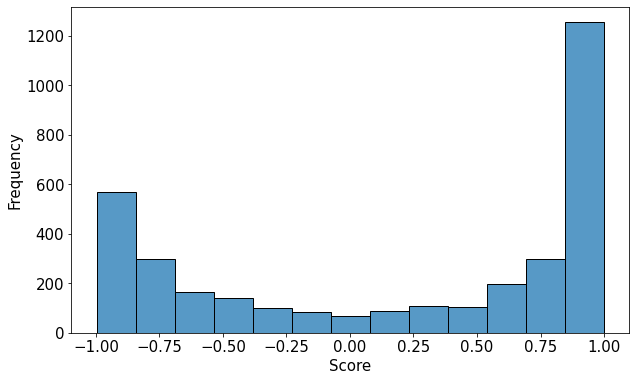

In [235]:
fig = plt.figure(facecolor='white',figsize=(10,6))
sns.histplot(data=df4,x='Score')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Score',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.savefig('Score.png',bbox_inches='tight')